#Importing Packages

In [ ]:
pip install turicreate

In [ ]:
import re
import turicreate as tc
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import string
import random


In [ ]:
import gc
import time
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

#Processing Dataset

In [ ]:
fashion = tc.SFrame.read_csv('/content/drive/My Drive/AMAZON_FASHION.csv',header = None)

Finished parsing file /content/drive/My Drive/AMAZON_FASHION.csv

Parsing completed. Parsed 100 lines in 3.10958 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,float,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/drive/My Drive/AMAZON_FASHION.csv

Parsing completed. Parsed 883636 lines in 1.10568 secs.

In [ ]:
fashion.rename({'X1':'ProdID','X2':'UserID','X3':'Rating','X4':'Timestamp'},inplace=True)
fashion.remove_column('Timestamp',inplace=True)
fashion

ProdID,UserID,Rating
7106116521,A1D4G1SNUZWQOT,5.0
7106116521,A3DDWDH9PX2YX2,2.0
7106116521,A2MWC41EW7XL15,4.0
7106116521,A2UH2QQ275NV45,2.0
7106116521,A89F3LQADZBS5,3.0
7106116521,A29HLOUW0NS0EH,5.0
7106116521,A7QS961ROI6E0,4.0
B00007GDFV,A1BB77SEBQT8VX,3.0
B00007GDFV,AHWOW7D1ABO9C,3.0
B00007GDFV,AKS3GULZE0HFC,3.0


In [ ]:
fashion_meta = tc.SFrame.read_json('/content/drive/My Drive/meta_AMAZON_FASHION.json',orient='lines')

Finished parsing file /content/drive/My Drive/meta_AMAZON_FASHION.json

Parsing completed. Parsed 100 lines in 2.77741 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 9221 lines. Lines per second: 3162.85

Read 45233 lines. Lines per second: 5368

Read 81028 lines. Lines per second: 5560.8

Read 116921 lines. Lines per second: 5795.16

Read 152574 lines. Lines per second: 5888.21

Finished parsing file /content/drive/My Drive/meta_AMAZON_FASHION.json

Parsing completed. Parsed 186627 lines in 29.3405 secs.

In [ ]:
fashion_meta.remove_columns(['tech1','price','also_buy','rank','also_view','description','feature','image','tech2','category','similar_item','details','main_cat','date','fit'],inplace = True)
fashion_meta.rename({'asin':'ProdID'},inplace=True)

ProdID,brand,title
630456984X,,Dante's Peak - Laserdisc
7106116521,,Milliongadgets(TM)Earring Safety Backs For ...
8037200124,Envirosax,Envirosax Kids SeriesJessie &amp; Lulu ...
8037200221,Envirosax,Envirosax GreengrocerSeries Bag 7 Guava ...
8279996567,Gifts by Lulee,Blessed by Pope BenedettoXVI Our Lady of Guada ...
9239282785,Tideclothes,Tideclothes ALAGIRLSStrapless Beading ...
9239281533,Tideclothes,ALAGIRLS StraplessBeading Homecoming Prom ...
9269808971,,Syma S107C 3channelCoaxial Mini Spy Cam ...
9654263246,Roar Carbon,"X. L. Carbon Fiber MoneyClip, made in the USA ..."
B00004T3SN,Shimmer Anne Shine,Shimmer Anne Shine ClipOn Costume/Halloween Cat ...


#Analyzing the data

Rating associate with each Products

In [ ]:
fashion.groupby(key_column_names='ProdID',operations={'mean_rating': tc.aggregate.MEAN('Rating'),'std_rating': tc.aggregate.STD('Rating')})

ProdID,mean_rating,std_rating
B00LVYEEPG,4.0,0.0
B0010TJ9FC,4.5,0.5
B00W0Z402M,5.0,0.0
B01CTQJ2ZQ,3.0,2.0
B00ZJD3FTG,5.0,0.0
B015IRGGF2,1.5,0.5
B005HBIYIW,3.0,0.0
B01DVB0TO6,3.0,2.0
B00NTJDUI8,4.0,0.0
B017XEPI6G,4.5,0.5000000000000001


mean and standard deviation of ratings per user.

In [ ]:
fashion.groupby(key_column_names='UserID',operations={'mean_rating': tc.aggregate.MEAN('Rating'),'std_rating': tc.aggregate.STD('Rating')})

UserID,mean_rating,std_rating
A1KTRP6I0YEPF4,5.0,0.0
A3FUPR2H79C8RL,5.0,0.0
A3A9LY4MT89JIY,5.0,0.0
A1FA177XLVW2YC,5.0,0.0
AU52XXO3CA4QE,5.0,0.0
A14WRMQHG2V84L,5.0,0.0
A1B9W1YG8PH91L,3.0,0.0
A2JFIL3PTLSM4B,5.0,0.0
AKLLJXYE1PNUH,2.0,0.0
A3OS63ZWKSA33Y,3.4285714285714284,1.178030178747903


Max rated movie by each User

In [ ]:
fashion.groupby(key_column_names='UserID', operations={('max_rated_movie'): tc.aggregate.ARGMAX('Rating','ProdID')})


UserID,max_rated_movie
A1KTRP6I0YEPF4,B00FN90O8G
A3FUPR2H79C8RL,B00M9O0FBE
A3A9LY4MT89JIY,B00XO8RUGC
A1FA177XLVW2YC,B01F4RWN9E
AU52XXO3CA4QE,B002FVPQWY
A14WRMQHG2V84L,B015BNKNWU
A1B9W1YG8PH91L,B01401RV4M
A2JFIL3PTLSM4B,B00NPORRFE
AKLLJXYE1PNUH,B0183JQHCO
A3OS63ZWKSA33Y,B009ERSRDM


#Spilting Dataset

In [ ]:
train,test = tc.recommender.util.random_split_by_user(fashion,user_id='UserID',item_id='ProdID',random_seed= 8)

#Model Training

In [ ]:
Popularity_model = tc.recommender.popularity_recommender.create(train,user_id ='UserID',item_id = 'ProdID',target = 'Rating')

Preparing data set.

Data has 883378 observations with 749042 users and 186167 items.

Data prepared in: 1.90757s

883378 observations to process; with 186167 unique items.

In [ ]:
Popularity_model.evaluate(test)


Precision and recall summary statistics by cutoff
+--------+----------------+-------------+
| cutoff | mean_precision | mean_recall |
+--------+----------------+-------------+
|   1    |      0.0       |     0.0     |
|   2    |      0.0       |     0.0     |
|   3    |      0.0       |     0.0     |
|   4    |      0.0       |     0.0     |
|   5    |      0.0       |     0.0     |
|   6    |      0.0       |     0.0     |
|   7    |      0.0       |     0.0     |
|   8    |      0.0       |     0.0     |
|   9    |      0.0       |     0.0     |
|   10   |      0.0       |     0.0     |
+--------+----------------+-------------+
[10 rows x 3 columns]


Overall RMSE: 1.2244830901109969

Per User RMSE (best)
+----------------+------+-------+
|     UserID     | rmse | count |
+----------------+------+-------+
| A1HOVUWG6PI959 | 0.0  |   1   |
+----------------+------+-------+
[1 rows x 3 columns]


Per User RMSE (worst)
+----------------+--------------------+-------+
|     UserID     | 

{'precision_recall_by_user': Columns:
 	UserID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 4464
 
 Data:
 +---------------+--------+-----------+--------+-------+
 |     UserID    | cutoff | precision | recall | count |
 +---------------+--------+-----------+--------+-------+
 | A17ST44YL27ER |   1    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   2    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   3    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   4    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   5    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   6    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   7    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   8    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   9    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   10   |    0.0    |  0.0   |   1   |
 +---------------+--------+-----------+--------+-------+
 [4464 rows x 5 columns]
 Note: Only the head of the SFrame is printed

In [ ]:
Cosine_similarity_model = tc.recommender.item_similarity_recommender.create(train,user_id='UserID', item_id= 'ProdID',target='Rating',similarity_type='cosine')

Preparing data set.

Data has 883378 observations with 749042 users and 186167 items.

Data prepared in: 2.14586s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 9.131ms                        | 0          |

| 114.463ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.22s                               | 0                | 0               |

| 2.40s                               | 100              | 186167          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 3.50437s

In [ ]:
Cosine_similarity_model.evaluate(test)


Precision and recall summary statistics by cutoff
+--------+-----------------------+----------------------+
| cutoff |     mean_precision    |     mean_recall      |
+--------+-----------------------+----------------------+
|   1    |  0.024193548387096774 | 0.024193548387096774 |
|   2    |  0.012096774193548387 | 0.024193548387096774 |
|   3    |  0.008064516129032258 | 0.024193548387096774 |
|   4    |  0.006048387096774193 | 0.024193548387096774 |
|   5    |  0.004838709677419355 | 0.024193548387096774 |
|   6    |  0.004032258064516129 | 0.024193548387096774 |
|   7    | 0.0034562211981566814 | 0.024193548387096774 |
|   8    | 0.0030241935483870967 | 0.024193548387096774 |
|   9    | 0.0026881720430107525 | 0.024193548387096774 |
|   10   | 0.0024193548387096775 | 0.024193548387096774 |
+--------+-----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 4.140294434292468

Per User RMSE (best)
+----------------+----------------------+-------+
|     Use

{'precision_recall_by_user': Columns:
 	UserID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 4464
 
 Data:
 +---------------+--------+---------------------+--------+-------+
 |     UserID    | cutoff |      precision      | recall | count |
 +---------------+--------+---------------------+--------+-------+
 | A17ST44YL27ER |   1    |         1.0         |  1.0   |   1   |
 | A17ST44YL27ER |   2    |         0.5         |  1.0   |   1   |
 | A17ST44YL27ER |   3    |  0.3333333333333333 |  1.0   |   1   |
 | A17ST44YL27ER |   4    |         0.25        |  1.0   |   1   |
 | A17ST44YL27ER |   5    |         0.2         |  1.0   |   1   |
 | A17ST44YL27ER |   6    | 0.16666666666666666 |  1.0   |   1   |
 | A17ST44YL27ER |   7    | 0.14285714285714285 |  1.0   |   1   |
 | A17ST44YL27ER |   8    |        0.125        |  1.0   |   1   |
 | A17ST44YL27ER |   9    |  0.1111111111111111 |  1.0   |   1   |
 | A17ST44YL27ER |   10   |         0.1         |  1.0   |   1  

In [ ]:
Pearson_model= tc.item_similarity_recommender.create(train,user_id='UserID',item_id = 'ProdID',target='Rating',similarity_type='pearson')

Preparing data set.

Data has 883378 observations with 749042 users and 186167 items.

Data prepared in: 2.32222s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 10.313ms                       | 0          |

| 118.233ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.54s                               | 0                | 0               |

| 2.73s                               | 100              | 186167          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.84032s

In [ ]:
Pearson_model.evaluate(test)


Precision and recall summary statistics by cutoff
+--------+----------------+-------------+
| cutoff | mean_precision | mean_recall |
+--------+----------------+-------------+
|   1    |      0.0       |     0.0     |
|   2    |      0.0       |     0.0     |
|   3    |      0.0       |     0.0     |
|   4    |      0.0       |     0.0     |
|   5    |      0.0       |     0.0     |
|   6    |      0.0       |     0.0     |
|   7    |      0.0       |     0.0     |
|   8    |      0.0       |     0.0     |
|   9    |      0.0       |     0.0     |
|   10   |      0.0       |     0.0     |
+--------+----------------+-------------+
[10 rows x 3 columns]


Overall RMSE: 1.7146226392963362

Per User RMSE (best)
+----------------+------+-------+
|     UserID     | rmse | count |
+----------------+------+-------+
| A1HOVUWG6PI959 | 0.0  |   1   |
+----------------+------+-------+
[1 rows x 3 columns]


Per User RMSE (worst)
+----------------+------+-------+
|     UserID     | rmse | count |

{'precision_recall_by_user': Columns:
 	UserID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 4464
 
 Data:
 +---------------+--------+-----------+--------+-------+
 |     UserID    | cutoff | precision | recall | count |
 +---------------+--------+-----------+--------+-------+
 | A17ST44YL27ER |   1    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   2    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   3    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   4    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   5    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   6    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   7    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   8    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   9    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   10   |    0.0    |  0.0   |   1   |
 +---------------+--------+-----------+--------+-------+
 [4464 rows x 5 columns]
 Note: Only the head of the SFrame is printed

In [ ]:
Jaccard_model= tc.item_similarity_recommender.create(train,user_id='UserID',item_id = 'ProdID',target='Rating',similarity_type='jaccard')

Preparing data set.

Data has 883378 observations with 749042 users and 186167 items.

Data prepared in: 2.07972s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 7.583ms                        | 0          |

| 116.662ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.11s                               | 0                | 0               |

| 2.30s                               | 100              | 186167          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.39978s

In [ ]:
Jaccard_model.evaluate(test)


Precision and recall summary statistics by cutoff
+--------+-----------------------+----------------------+
| cutoff |     mean_precision    |     mean_recall      |
+--------+-----------------------+----------------------+
|   1    |  0.024193548387096774 | 0.024193548387096774 |
|   2    |  0.012096774193548387 | 0.024193548387096774 |
|   3    |  0.008064516129032258 | 0.024193548387096774 |
|   4    |  0.006048387096774193 | 0.024193548387096774 |
|   5    |  0.004838709677419355 | 0.024193548387096767 |
|   6    |  0.004032258064516129 | 0.024193548387096767 |
|   7    | 0.0034562211981566814 | 0.024193548387096763 |
|   8    | 0.0030241935483870967 | 0.024193548387096774 |
|   9    | 0.0026881720430107516 | 0.024193548387096763 |
|   10   | 0.0024193548387096775 | 0.024193548387096763 |
+--------+-----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 4.1733509231355415

Per User RMSE (best)
+----------------+--------------------+-------+
|     User

{'precision_recall_by_user': Columns:
 	UserID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 4464
 
 Data:
 +---------------+--------+---------------------+--------+-------+
 |     UserID    | cutoff |      precision      | recall | count |
 +---------------+--------+---------------------+--------+-------+
 | A17ST44YL27ER |   1    |         1.0         |  1.0   |   1   |
 | A17ST44YL27ER |   2    |         0.5         |  1.0   |   1   |
 | A17ST44YL27ER |   3    |  0.3333333333333333 |  1.0   |   1   |
 | A17ST44YL27ER |   4    |         0.25        |  1.0   |   1   |
 | A17ST44YL27ER |   5    |         0.2         |  1.0   |   1   |
 | A17ST44YL27ER |   6    | 0.16666666666666666 |  1.0   |   1   |
 | A17ST44YL27ER |   7    | 0.14285714285714285 |  1.0   |   1   |
 | A17ST44YL27ER |   8    |        0.125        |  1.0   |   1   |
 | A17ST44YL27ER |   9    |  0.1111111111111111 |  1.0   |   1   |
 | A17ST44YL27ER |   10   |         0.1         |  1.0   |   1  

#Training Factorization based models

The factor terms model interactions between users and items. For example, if a user tends to love romance movies and hate action movies, the factor terms attempt to capture that, causing the model to predict lower scores for action movies and higher scores for romance movies. Learning good weights and factors is controlled by several options outlined below.

More formally, when side data is not present, the predicted score for user i on item j is given by

                   score(i,j)=μ+wi+wj+aTxi+bTyj+uTivj


where μ is a global bias term, wi is the weight term for user i, wj is the weight term for item j, xi and yj are respectively the user and item side feature vectors, and a and b are respectively the weight vectors for those side features. The latent factors, which are vectors of length num_factors, are given by ui and vj.

When binary_target=True, the above score is passed through a logistic function:

                   score(i,j)=1/(1+exp(−z))

where z is the original linear score.



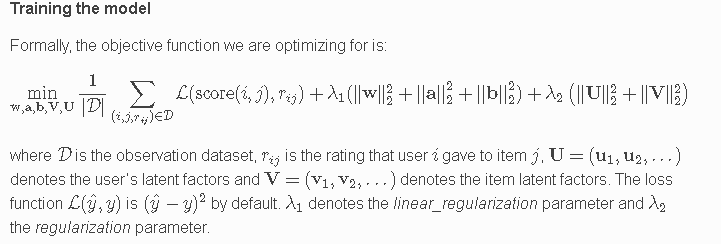

In [ ]:
factorization_recommender_model_sgd = tc.recommender.factorization_recommender.create(train,user_id = 'UserID',item_id = 'ProdID',target= 'Rating',max_iterations=150,
                                                          regularization=1e-05,solver = 'sgd',linear_regularization = 1e-05)

Preparing data set.

Data has 883378 observations with 749042 users and 186167 items.

Data prepared in: 2.04083s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-05    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-05    |

| max_iterations                 | Maximum Number of Iterations                     | 150      |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 110422 / 883378 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 8.34067           | 0.895493                                 |

| 1       | 4.17034           | 0.910325                                 |

| 2       | 2.08517           | 0.875187                                 |

| 3       | 1.04258           | 0.882723                                 |

| 4       | 0.521292          | 0.908592                                 |

| 5       | 0.260646          | 0.85509                                  |

| 6       | 0.130323          | 0.814629                                 |

| 7       | 0.0651615         | 0.890008                                 |

| 8       | 0.0325807         | 1.13805                                  |

| 9       | 0.0162904         | 1.4178                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.130323          | 0.814629                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 122us        | 2.01158           | 1.4183                |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 289.266ms    | 2.76825           | 1.36867               | 0.130323    |

| 2       | 558.438ms    | 2.05063           | 1.11502               | 0.0605803   |

| 3       | 814.46ms     | 1.85492           | 1.02992               | 0.039462    |

| 4       | 1.07s        | 1.75187           | 0.986635              | 0.0280691   |

| 5       | 1.33s        | 1.69636           | 0.959739              | 0.022492    |

| 10      | 2.61s        | 1.60867           | 0.909827              | 0.011283    |

| 25      | 6.37s        | 1.56376           | 0.874748              | 0.00452211  |

| 50      | 12.69s       | 1.55075           | 0.858695              | 0.00223114  |

| 75      | 19.02s       | 1.54362           | 0.850689              | 0.000639197 |

| 100     | 25.33s       | 1.54128           | 0.848615              | 9.1066e-05  |

| 109     | 27.61s       | 1.54123           | 0.848531              | 8.53662e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 1.54153

Final training RMSE: 0.848708

In [ ]:
factorization_recommender_model_sgd.evaluate(test)


Precision and recall summary statistics by cutoff
+--------+-----------------------+----------------------+
| cutoff |     mean_precision    |     mean_recall      |
+--------+-----------------------+----------------------+
|   1    |          0.0          |         0.0          |
|   2    |  0.004032258064516129 | 0.008064516129032258 |
|   3    | 0.0026881720430107525 | 0.00806451612903226  |
|   4    |  0.002016129032258065 | 0.00806451612903226  |
|   5    |  0.002419354838709678 | 0.012096774193548392 |
|   6    | 0.0020161290322580645 | 0.012096774193548392 |
|   7    | 0.0017281105990783407 | 0.012096774193548392 |
|   8    | 0.0015120967741935488 | 0.01209677419354839  |
|   9    | 0.0013440860215053762 | 0.012096774193548392 |
|   10   | 0.0012096774193548388 | 0.012096774193548392 |
+--------+-----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.2181200904796254

Per User RMSE (best)
+----------------+---------------------+-------+
|     Use

{'precision_recall_by_user': Columns:
 	UserID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 4464
 
 Data:
 +---------------+--------+-----------+--------+-------+
 |     UserID    | cutoff | precision | recall | count |
 +---------------+--------+-----------+--------+-------+
 | A17ST44YL27ER |   1    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   2    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   3    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   4    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   5    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   6    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   7    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   8    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   9    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   10   |    0.0    |  0.0   |   1   |
 +---------------+--------+-----------+--------+-------+
 [4464 rows x 5 columns]
 Note: Only the head of the SFrame is printed

In [ ]:
factorization_recommender_model_adagrad = tc.recommender.factorization_recommender.create(train,user_id = 'UserID',item_id = 'ProdID',target= 'Rating',max_iterations=200,
                                                          regularization=1e-05,solver = 'adagrad',linear_regularization = 1e-05)

Preparing data set.

Data has 883378 observations with 749042 users and 186167 items.

Data prepared in: 2.01932s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-05    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-05    |

| max_iterations                 | Maximum Number of Iterations                     | 200      |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 110422 / 883378 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 8.34067           | No Decrease (3.08238 >= 2.00247)         |

| 1       | 2.08517           | No Decrease (2.81617 >= 2.00247)         |

| 2       | 0.521292          | 1.44414                                  |

| 3       | 0.260646          | 1.29761                                  |

| 4       | 0.130323          | 1.15412                                  |

| 5       | 0.0651615         | 1.15422                                  |

| 6       | 0.0325807         | 1.37907                                  |

| 7       | 0.0162904         | 1.65477                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.130323          | 1.15412                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 124us        | 2.01158           | 1.4183                |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 418.041ms    | 2.4649            | 1.35596               | 0.130323    |

| 2       | 826.563ms    | 2.09818           | 1.21186               | 0.130323    |

| 3       | 1.22s        | 2.00358           | 1.10636               | 0.130323    |

| 4       | 1.61s        | 1.91871           | 1.02633               | 0.130323    |

| 5       | 2.01s        | 1.88637           | 0.980804              | 0.130323    |

| 10      | 3.95s        | 1.77489           | 0.901242              | 0.130323    |

| 20      | 7.86s        | 1.67598           | 0.876665              | 0.130323    |

| 30      | 11.75s       | 1.63583           | 0.86204               | 0.130323    |

| 40      | 15.72s       | 1.62041           | 0.85266               | 0.130323    |

| 50      | 19.65s       | 1.6184            | 0.846074              | 0.130323    |

| 60      | 23.57s       | 1.61447           | 0.83913               | 0.130323    |

| 70      | 27.55s       | 1.61166           | 0.833554              | 0.130323    |

| 80      | 31.59s       | 1.61251           | 0.830253              | 0.130323    |

| 90      | 35.57s       | 1.60979           | 0.825669              | 0.130323    |

| 100     | 39.54s       | 1.60764           | 0.822562              | 0.130323    |

| 110     | 43.53s       | 1.61136           | 0.821196              | 0.130323    |

| 120     | 47.46s       | 1.60619           | 0.818004              | 0.130323    |

| 130     | 51.41s       | 1.60653           | 0.817035              | 0.130323    |

| 140     | 55.37s       | 1.60755           | 0.815112              | 0.130323    |

| 150     | 59.34s       | 1.60916           | 0.813977              | 0.130323    |

| 160     | 1m 3s        | 1.60832           | 0.812997              | 0.130323    |

| 170     | 1m 7s        | 1.60775           | 0.811355              | 0.130323    |

| 180     | 1m 11s       | 1.60974           | 0.810904              | 0.130323    |

| 190     | 1m 15s       | 1.60854           | 0.809118              | 0.130323    |

| 200     | 1m 19s       | 1.60899           | 0.809192              | 0.130323    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.66571

Final training RMSE: 0.843513

In [ ]:
factorization_recommender_model_adagrad.evaluate(test)


Precision and recall summary statistics by cutoff
+--------+-----------------------+----------------------+
| cutoff |     mean_precision    |     mean_recall      |
+--------+-----------------------+----------------------+
|   1    |  0.00403225806451613  | 0.00403225806451613  |
|   2    |  0.008064516129032258 | 0.016129032258064516 |
|   3    |  0.005376344086021505 | 0.01612903225806452  |
|   4    |  0.00403225806451613  | 0.01612903225806452  |
|   5    | 0.0032258064516129032 | 0.01612903225806452  |
|   6    | 0.0026881720430107525 | 0.01612903225806452  |
|   7    |  0.002304147465437788 | 0.01612903225806452  |
|   8    |  0.002016129032258065 | 0.01612903225806452  |
|   9    | 0.0017921146953405018 | 0.01612903225806452  |
|   10   | 0.0016129032258064516 | 0.01612903225806452  |
+--------+-----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.2191286949013065

Per User RMSE (best)
+----------------+----------------------+-------+
|     Us

{'precision_recall_by_user': Columns:
 	UserID	str
 	cutoff	int
 	precision	float
 	recall	float
 	count	int
 
 Rows: 4464
 
 Data:
 +---------------+--------+-----------+--------+-------+
 |     UserID    | cutoff | precision | recall | count |
 +---------------+--------+-----------+--------+-------+
 | A17ST44YL27ER |   1    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   2    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   3    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   4    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   5    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   6    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   7    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   8    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   9    |    0.0    |  0.0   |   1   |
 | A17ST44YL27ER |   10   |    0.0    |  0.0   |   1   |
 +---------------+--------+-----------+--------+-------+
 [4464 rows x 5 columns]
 Note: Only the head of the SFrame is printed

In [ ]:
factorization_recommender_model_adagrad.recommend([test['UserID'][100]])

UserID,ProdID,score,rank
A3FED0M1J8NKZ9,B013SLWJJW,4.92935564451108,1
A3FED0M1J8NKZ9,B0148B7EJ6,4.866838239954806,2
A3FED0M1J8NKZ9,B00STV1K9W,4.822460912989474,3
A3FED0M1J8NKZ9,B014EB2ADA,4.822077357100344,4
A3FED0M1J8NKZ9,B018RMQV2S,4.818664156721926,5
A3FED0M1J8NKZ9,B005F0IBCO,4.8168168299664025,6
A3FED0M1J8NKZ9,B00U02CTZM,4.811502301024294,7
A3FED0M1J8NKZ9,B0006HB4XE,4.8103407257069115,8
A3FED0M1J8NKZ9,B00123KGXU,4.804353319929934,9
A3FED0M1J8NKZ9,B00M21O9L6,4.802634977625704,10


In [ ]:
list(factorization_recommender_model_adagrad.recommend([test['UserID'][100]])['ProdID'])

['B013SLWJJW',
 'B0148B7EJ6',
 'B00STV1K9W',
 'B014EB2ADA',
 'B018RMQV2S',
 'B005F0IBCO',
 'B00U02CTZM',
 'B0006HB4XE',
 'B00123KGXU',
 'B00M21O9L6']

In [ ]:
factorization_recommender_model_adagrad.coefficients['UserID']

UserID,linear_terms,factors
A1D4G1SNUZWQOT,0.1986227035522461,"[0.060564953833818436,-0.05015077441930771, ..."
A3DDWDH9PX2YX2,-0.11359886825084686,"[-0.10572709888219833,0.08819446712732315, ..."
A2MWC41EW7XL15,0.03128080070018768,"[0.009506972506642342,-0.007834040559828281, ..."
A2UH2QQ275NV45,-0.2996751666069031,"[-0.09011372923851013,0.07516402006149292, ..."
A89F3LQADZBS5,-0.13726596534252167,"[-0.04159163311123848,0.03432837128639221, ..."
A29HLOUW0NS0EH,0.20097559690475464,"[0.06642847508192062,-0.05616079270839691, ..."
A7QS961ROI6E0,0.03142938390374184,"[0.009675352834165096,-0.007970898412168026, ..."
A1BB77SEBQT8VX,-0.04814040660858154,"[-0.05222608149051666,-0.05173157900571823, ..."
AHWOW7D1ABO9C,0.14858826994895935,"[-0.06644463539123535,-0.06544028967618942, ..."
AKS3GULZE0HFC,-0.04796642065048218,"[-0.052164215594530106,-0.051669999957084656, ..."


In [ ]:
factorization_recommender_model_adagrad.coefficients['ProdID']

ProdID,linear_terms,factors
7106116521,-0.09033428877592087,"[0.2904115617275238,-0.2454814612865448, ..."
B00007GDFV,-0.2401818484067917,"[1.0440757274627686,1.0336970090866089, ..."
B00008JOQI,-0.21459487080574036,"[-0.6510534882545471,0.6316325664520264, ..."
B00008JQF0,-0.03333543241024017,"[-0.4331558346748352,0.3797589838504791, ..."
B00008JVTT,0.33034348487854004,"[0.12328675389289856,0.20447158813476562, ..."
B00008JPRZ,0.45138609409332275,"[-0.02316809818148613,0.034053999930620193, ..."
B0000AWHAA,-0.12228750437498093,"[0.3477047383785248,-0.34771597385406494, ..."
B0000AWXMM,0.4358275830745697,"[-4.666737004299648e-05,-4.467847975320183e-05, ..."
B0000AWX3V,-0.2122994065284729,"[0.25527769327163696,-0.2552456855773926, ..."
B00015VKT4,0.5358326435089111,"[-0.001390443998388946,0.001354757696390152, ..."


In [ ]:
# below code is use to save model in drive
#factorization_recommender_model_adagrad.save("/content/drive/My Drive/recommender.model")
#the final recommender is in Final_dataset notebook